In [1]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import keras
import time
import pandas as pd
import time as time
from tqdm import tqdm, trange

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


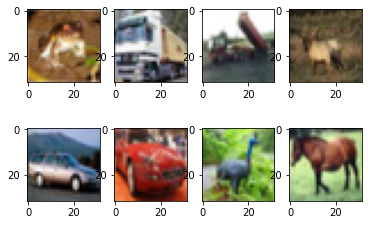

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

Model I is a CNN model, which could distinguish meaningful features in an image in order to classify the image as a whole. 

To achieve this, CNN uses different layers, the convolution layer, which could convolve the input image into a feature map that emphasize the important features. The more convolution layers we put, the more features the model could detect.

After convolution layer is the max pooling layer, which replace the output from the convolution layer with a max summary to reduce data size and processing time.
Here we choose the size to be 2*2 which determines how big the value pools in every step.
Then we drop out part of the data to preventing overfitting.

After several layers to filter important features, we flatten the feature outputs to column vector and fully connect it to the previous layers.
Finally, we wrap our features with softmax activation and we are able to classify the image. 

In [8]:
# Assign Required Variables
X_train = tf.cast(imgs, dtype='float32')/255.0
y_train = tf.one_hot(noisy_labels, depth=10)
X_test = tf.cast(imgs[:10000], dtype='float32')/255.0
X_test_img = imgs[:10000]
y_test = tf.one_hot(clean_labels, depth = 10)

In [9]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

def model1():
    
    start_time = time.time()
    
    # build CNN
    modelI = tf.keras.Sequential([
        # First do feature extraction, every convolution and maxpooling works as a layer
        #Creates a convolution kernel with kernel size 32 and strides (3,3), use padding = "same" so input is half padded
        tf.keras.layers.Conv2D(32,(3,3),padding='same', activation ='relu', input_shape=(32,32,3)),
        #(2, 2) will take the max value over a 2x2 pooling window
        tf.keras.layers.MaxPooling2D((2,2)),
        #Drop out function drops out part of the data to prevent overfitting
        tf.keras.layers.Dropout(0.3),
        
        #Creates a convolution kernel with kernel size 64 and strides (3,3)
        tf.keras.layers.Conv2D(64,(3,3),padding='same', activation ='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.3),
        
        #Creates a convolution kernel with kernel size 96 and strides (3,3)
        tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.3),
        
        #Creates a convolution kernel with kernel size 64 and strides (3,3)
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        
        #from here we have a dense network and start do classification
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(0.3),
    
        tf.keras.layers.Dense(10, activation = 'softmax')        
                                ])
        
    modelI.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                 #categoricalCrossentropy here decides that CNN is used
                 loss = tf.keras.losses.CategoricalCrossentropy(),
                 metrics = ['accuracy'])
    
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3)

    class TimeHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.times = []

        def on_epoch_begin(self, epoch, logs={}):
            self.epoch_time_start = time.time()

        def on_epoch_end(self, epoch, logs={}):
            self.times.append(time.time() - self.epoch_time_start)

    time_callback = TimeHistory()
    
    modelI.fit(X_train, y_train, batch_size= 128, epochs=10,
          validation_split= 0.2, callbacks=[early_stop, time_callback])
    
    print("--- model took %s seconds ---" % (time.time() - start_time))
    
    return(modelI)

In [10]:
modelI = model1()

Epoch 1/10
313/313 [==============================] - 29s 90ms/step - loss: 2.2961 - accuracy: 0.1172 - val_loss: 2.2864 - val_accuracy: 0.1342
Epoch 2/10
313/313 [==============================] - 30s 95ms/step - loss: 2.2778 - accuracy: 0.1468 - val_loss: 2.2658 - val_accuracy: 0.1645
Epoch 3/10
313/313 [==============================] - 31s 100ms/step - loss: 2.2597 - accuracy: 0.1649 - val_loss: 2.2433 - val_accuracy: 0.1824
Epoch 4/10
313/313 [==============================] - 30s 96ms/step - loss: 2.2503 - accuracy: 0.1798 - val_loss: 2.2457 - val_accuracy: 0.1877
Epoch 5/10
313/313 [==============================] - 30s 94ms/step - loss: 2.2405 - accuracy: 0.1897 - val_loss: 2.2292 - val_accuracy: 0.2065
Epoch 6/10
313/313 [==============================] - 32s 101ms/step - loss: 2.2340 - accuracy: 0.1964 - val_loss: 2.2219 - val_accuracy: 0.2122
Epoch 7/10
313/313 [==============================] - 33s 104ms/step - loss: 2.2268 - accuracy: 0.2048 - val_loss: 2.2162 - val_accura

In [11]:
def model_I(image):
    # Data Normalization
    image = tf.cast(image, dtype='float32')/255.0
    prelabel = modelI.predict(image[np.newaxis,...])
    # Convert From One Hot Vector to Scalar
    maxlabel = np.argmax(prelabel)
    return(maxlabel)

### 2.3. Model II

For Model II, we basically reproduced the method proposed from paper **"Learning From Noisy Large-Scale Datasets With Minimal Supervision"** (Andreas Veit et al, Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2017, pp. 839-847). The main idea is to correct the noisy label and then use the corrected label as input to improve Model I. The correction procedure is: 

1. Train the Label Cleaning Network using the clean label and the coresponding concatenated label. The concatenated label is the combination of predicted label from Model I and the coresponding noisy label. The Label Cleaning Network has several linear layers.
2. Use the Label Cleaning Network to process the whole predicted label from Model I and the coresponding noisy label to generate a set of corrected label, and then combining this set of corrected label with Model I to train Model II.

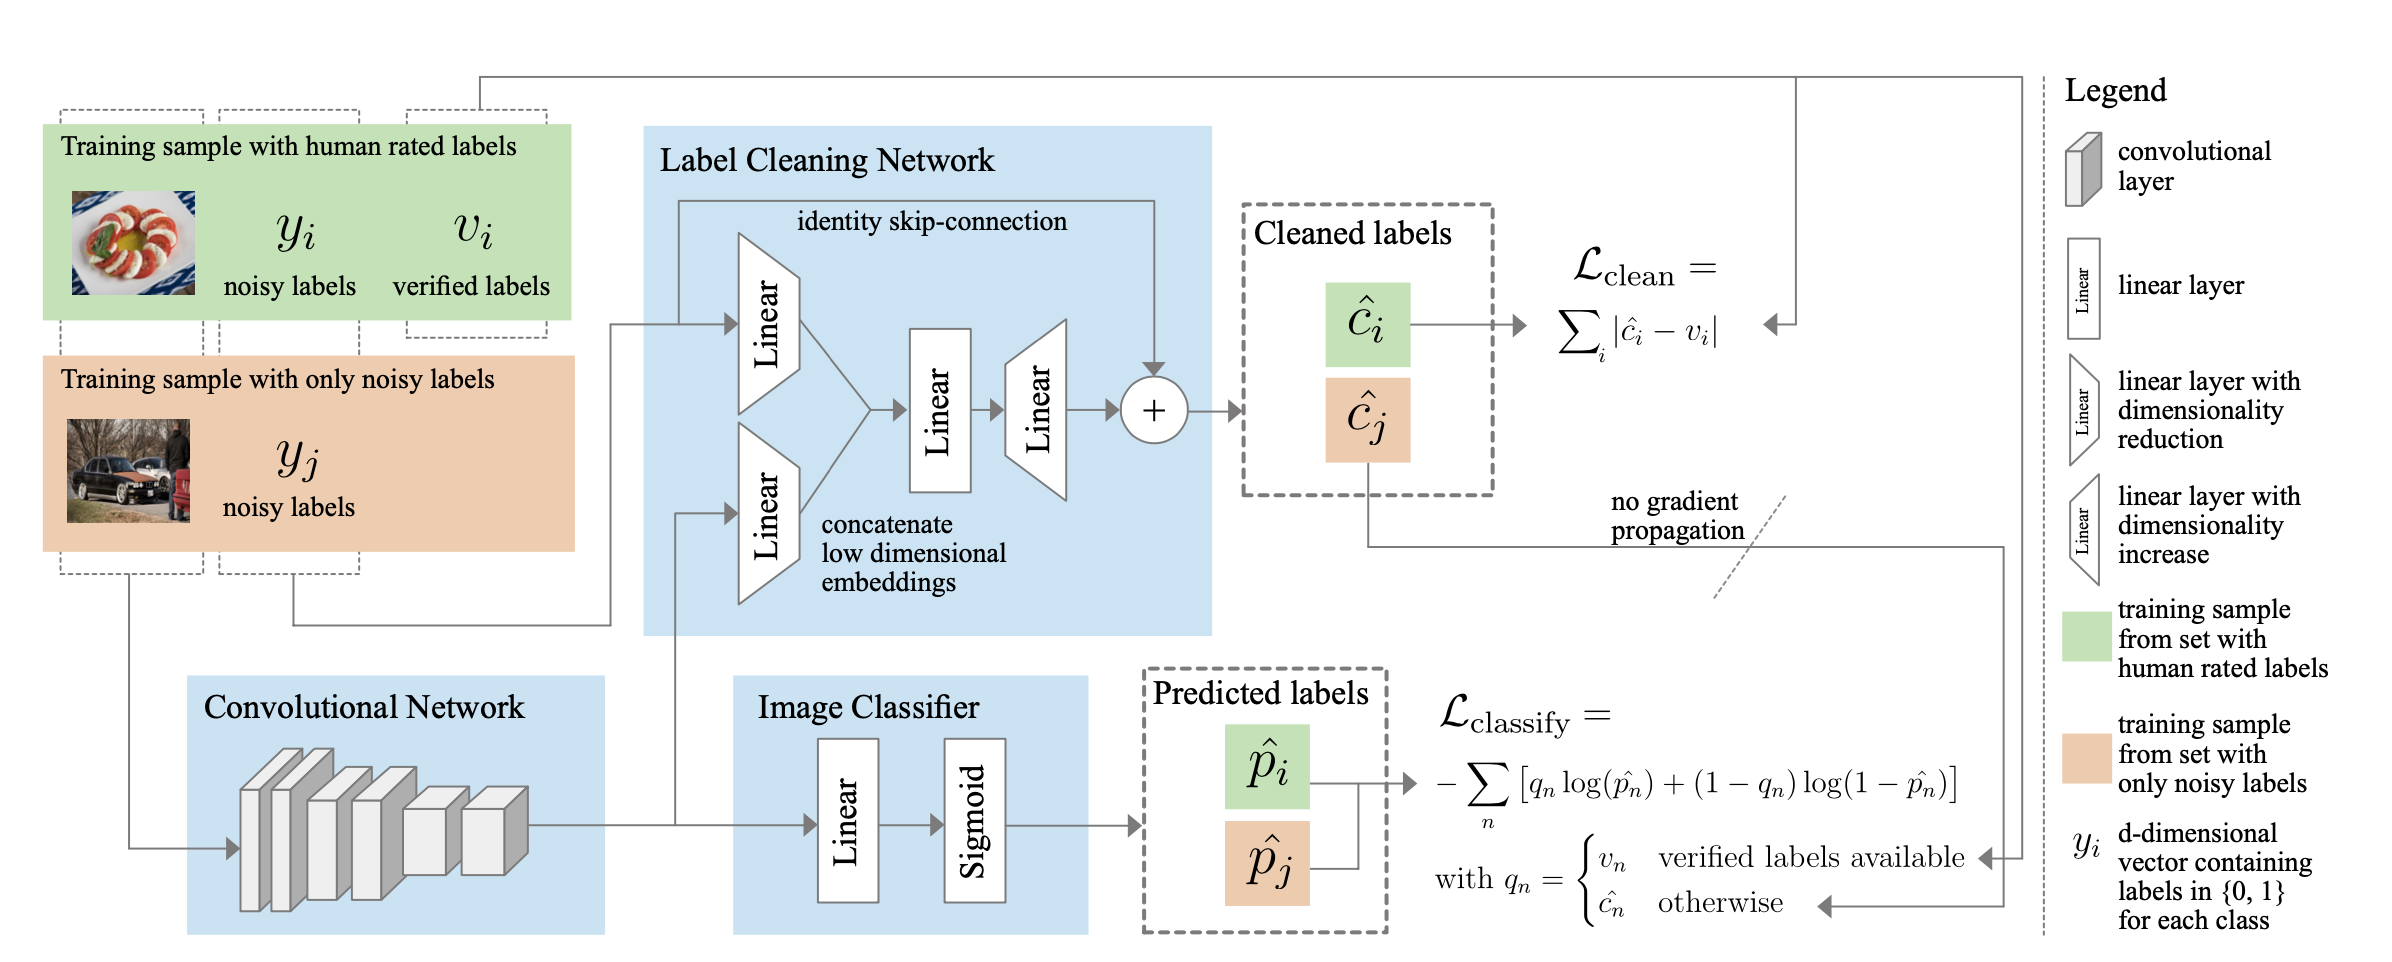

In [12]:
# Import Clarification Image
from IPython.display import Image
Image(filename = '../data/clean label.png')

*Cited from **"Learning From Noisy Large-Scale Datasets With Minimal Supervision"** (Andreas Veit et al, Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2017, pp. 839-847)*

In [13]:
# Prepare Label Correction Training Data
y_noisyall = tf.one_hot(noisy_labels,depth = 10).numpy()

# Predicted Labels From Model 1
y_predall = []
for i in trange(n_img):
    y_predall.append(modelI.predict(X_train[i][np.newaxis,...])[0])
    
y_predall = np.array(y_predall)

# Concatenate Predicted Labels & Noisy Labels
y_comball = []
y_comball = np.hstack((y_predall, y_noisyall))

# Supervide Label Correction Model Using Clean Labels
y_true = tf.one_hot(clean_labels,depth = 10).numpy()

100%|██████████| 50000/50000 [26:33<00:00, 31.39it/s]


In [14]:
label_correction = tf.keras.Sequential([
 # First Linear Layer
 tf.keras.layers.Dense(50, activation = "linear"),
 # First Relu Layer
 tf.keras.layers.Dense(20, activation = "relu"),
 # Batch Normalization to Standardize
 tf.keras.layers.BatchNormalization(),  
 # Second Linear Layer
 tf.keras.layers.Dense(20, activation = "linear"),  
 # Return a Probabilities Vector
 tf.keras.layers.Dense(10, activation = 'softmax')
])

label_correction.compile(
    optimizer='adam',
    # Mean Abosolute Error as Loss Function
    loss = 'MeanAbsoluteError',
    metrics = ['accuracy']
)

# Use the first 100000 Images, Noisy Labels & Clean Labels to Train Model
label_correction.fit(y_comball[:10000], y_true, epochs=10)

Epoch 1/10
313/313 [==============================] - 1s 1ms/step - loss: 0.1300 - accuracy: 0.3812
Epoch 2/10
313/313 [==============================] - 0s 983us/step - loss: 0.1022 - accuracy: 0.5069
Epoch 3/10
313/313 [==============================] - 0s 1ms/step - loss: 0.0936 - accuracy: 0.5449
Epoch 4/10
313/313 [==============================] - 0s 1ms/step - loss: 0.0911 - accuracy: 0.5548
Epoch 5/10
313/313 [==============================] - 0s 1ms/step - loss: 0.0894 - accuracy: 0.5610
Epoch 6/10
313/313 [==============================] - 0s 1ms/step - loss: 0.0884 - accuracy: 0.5657
Epoch 7/10
313/313 [==============================] - 0s 1ms/step - loss: 0.0871 - accuracy: 0.5711
Epoch 8/10
313/313 [==============================] - 0s 1ms/step - loss: 0.0867 - accuracy: 0.5714
Epoch 9/10
313/313 [==============================] - 0s 1ms/step - loss: 0.0856 - accuracy: 0.5774
Epoch 10/10
313/313 [==============================] - 0s 1ms/step - loss: 0.0854 - accuracy: 0.57

In [15]:
corlabel = []
# Input All Noisy Labels & Images
corrlabel = label_correction.predict(y_comball)
# Output Corrected Labels to Train Model 1
for i in range(len(corrlabel)):
    corlabel.append(np.array(tf.one_hot(np.argmax(corrlabel[i]),depth = 10)))
corlabel = np.array(corlabel)

In [16]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

def model2():
    
    start_time = time.time()
    
    # build CNN
    modelII = tf.keras.Sequential([
        # First do feature extraction, every convolution and maxpooling works as a layer
        #Creates a convolution kernel with kernel size 32 and strides (3,3), use padding = "same" so input is half padded
        tf.keras.layers.Conv2D(32,(3,3),padding='same', activation ='relu', input_shape=(32,32,3)),
        #(2, 2) will take the max value over a 2x2 pooling window
        tf.keras.layers.MaxPooling2D((2,2)),
        #Drop out function drops out part of the data to prevent overfitting
        tf.keras.layers.Dropout(0.3),
        
        #Creates a convolution kernel with kernel size 64 and strides (3,3)
        tf.keras.layers.Conv2D(64,(3,3),padding='same', activation ='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.3),
        
        #Creates a convolution kernel with kernel size 96 and strides (3,3)
        tf.keras.layers.Conv2D(96, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.3),
        
        #Creates a convolution kernel with kernel size 64 and strides (3,3)
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        
        #from here we have a dense network and start do classification
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(0.3),
    
        tf.keras.layers.Dense(10, activation = 'softmax')        
                                ])
        
    modelII.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                 #categoricalCrossentropy here decides that CNN is used
                 loss = tf.keras.losses.CategoricalCrossentropy(),
                 metrics = ['accuracy'])
    
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3)

    class TimeHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.times = []

        def on_epoch_begin(self, epoch, logs={}):
            self.epoch_time_start = time.time()

        def on_epoch_end(self, epoch, logs={}):
            self.times.append(time.time() - self.epoch_time_start)

    time_callback = TimeHistory()
    
    # Utilized Corrected Labels to Train the Exact Same Model
    modelII.fit(X_train, corlabel, batch_size= 128, epochs=10,
          validation_split= 0.2, callbacks=[early_stop, time_callback])
    
    print("--- model took %s seconds ---" % (time.time() - start_time))
    
    return(modelII)

In [17]:
modelII = model2()

Epoch 1/10
313/313 [==============================] - 32s 101ms/step - loss: 1.7915 - accuracy: 0.3492 - val_loss: 1.4460 - val_accuracy: 0.4940
Epoch 2/10
313/313 [==============================] - 31s 101ms/step - loss: 1.4137 - accuracy: 0.4898 - val_loss: 1.2229 - val_accuracy: 0.5608
Epoch 3/10
313/313 [==============================] - 33s 106ms/step - loss: 1.3173 - accuracy: 0.5253 - val_loss: 1.1745 - val_accuracy: 0.5853
Epoch 4/10
313/313 [==============================] - 33s 105ms/step - loss: 1.2645 - accuracy: 0.5430 - val_loss: 1.1632 - val_accuracy: 0.5794
Epoch 5/10
313/313 [==============================] - 30s 97ms/step - loss: 1.2362 - accuracy: 0.5565 - val_loss: 1.1462 - val_accuracy: 0.5880
Epoch 6/10
313/313 [==============================] - 30s 96ms/step - loss: 1.2071 - accuracy: 0.5663 - val_loss: 1.1095 - val_accuracy: 0.5952
Epoch 7/10
313/313 [==============================] - 30s 95ms/step - loss: 1.1909 - accuracy: 0.5706 - val_loss: 1.1112 - val_accur

In [18]:
def model_II(image):
    # Data Normalization
    image = tf.cast(image, dtype='float32')/255.0
    prelabel = modelII.predict(image[np.newaxis,...])
    # Convert From One Hot Vector to Scalar
    maxlabel = np.argmax(prelabel)
    return(maxlabel)

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [19]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [23]:
# Baseline model Evaluation
start_time = time.time()
evaluation(baseline_model, clean_labels, X_test_img)
print("--- evaluation took %s seconds ---" % (time.time() - start_time))

              precision    recall  f1-score   support

           0       0.32      0.43      0.37      1005
           1       0.18      0.29      0.22       974
           2       0.22      0.04      0.07      1032
           3       0.19      0.12      0.14      1016
           4       0.24      0.48      0.32       999
           5       0.22      0.13      0.16       937
           6       0.26      0.35      0.30      1030
           7       0.29      0.04      0.07      1001
           8       0.28      0.43      0.34      1025
           9       0.19      0.11      0.14       981

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000

--- evaluation took 3.2456419467926025 seconds ---


In [21]:
# Model 1 Evaluation
start_time = time.time()
evaluation(model_I, clean_labels, X_test_img)
print("--- evaluation took %s seconds ---" % (time.time() - start_time))

              precision    recall  f1-score   support

           0       0.58      0.51      0.54      1005
           1       0.64      0.70      0.67       974
           2       0.46      0.16      0.24      1032
           3       0.38      0.25      0.30      1016
           4       0.35      0.46      0.40       999
           5       0.40      0.39      0.39       937
           6       0.51      0.70      0.59      1030
           7       0.50      0.65      0.56      1001
           8       0.62      0.65      0.64      1025
           9       0.61      0.62      0.61       981

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.49     10000
weighted avg       0.50      0.51      0.49     10000

--- evaluation took 313.91918110847473 seconds ---


In [22]:
# Model 2 Evaluation
start_time = time.time()
evaluation(model_II, clean_labels, X_test_img)
print("--- evaluation took %s seconds ---" % (time.time() - start_time))

              precision    recall  f1-score   support

           0       0.66      0.40      0.50      1005
           1       0.59      0.79      0.68       974
           2       0.53      0.01      0.02      1032
           3       0.30      0.67      0.42      1016
           4       0.37      0.54      0.44       999
           5       0.64      0.08      0.15       937
           6       0.59      0.62      0.61      1030
           7       0.60      0.61      0.60      1001
           8       0.61      0.76      0.67      1025
           9       0.68      0.59      0.63       981

    accuracy                           0.51     10000
   macro avg       0.56      0.51      0.47     10000
weighted avg       0.56      0.51      0.47     10000

--- evaluation took 317.8390429019928 seconds ---


In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

In [ ]:
# Model 1 Evaluation on Test Data Set
evaluation(model_I, test_labels, test_imgs)

In [ ]:
# Model 2 Evaluation on Test Data Set
evaluation(model_II, test_labels, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

## 4. Prediction on the test data

In [ ]:
n_test = 10000
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

In [27]:
index = np.array(range(1,10001))
Baseline = []
Model__I = []
Model__II = []

for i in range(n_test):
    Baseline.append(baseline_model(test_imgs[i])[0])
    Model__I.append(model_I(test_imgs[i]))
    Model__II.append(model_II(test_imgs[i]))
dic = {'Index' : index, 'Baseline' : Baseline, 'Model I' : Model__I, 'Model II' : Model__II}
output = pd.DataFrame(dic)
# Write Out Label_Prediction.csv
output.to_csv("../output/label_prediction.csv")
print("--- prediction took %s seconds ---" % (time.time() - start_time))

--- evaluation took 6.904134750366211 seconds ---
